# Trabajo Práctico 7
1. El conjunto de datos clásico de caras Olivetti contiene 400 imágenes de caras en escala de grises de 64 × 64 píxeles. Cada imagen se aplana en un vector 1D de tamaño 4,096. Se fotografiaron 40 personas diferentes (10 veces cada una), y la tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen. Cargue el conjunto de datos utilizando la función sklearn.datasets.fetch_olivetti_faces(), luego divídalo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de prueba (note que el conjunto de datos ya está escalado entre 0 y 1). Dado que el conjunto de datos es bastante pequeño, probablemente desee utilizar un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto. A continuación, agrupe las imágenes utilizando K-Means y asegúrese de tener un buen número de clústeres (usando una de las técnicas discutidas en este capítulo). Visualice los clústeres: ¿ve caras similares en cada clúster?

In [1]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

# Cargamos los datos
faces = fetch_olivetti_faces()
X = faces.data
y = faces.target

# Dividimos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

In [2]:
from sklearn.cluster import KMeans

# Utilizamos KMeans para agrupar las imagenes y lo entrenamos

n = 130  # Número de clusters
kmeans = KMeans(n_clusters=n, random_state=42)
kmeans.fit(X_train)

/home/fran/Documentos/5 AÑO/Sistemas Inteligentes carpeta/Sistemas-Inteligentes/sappienv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=130, random_state=42)

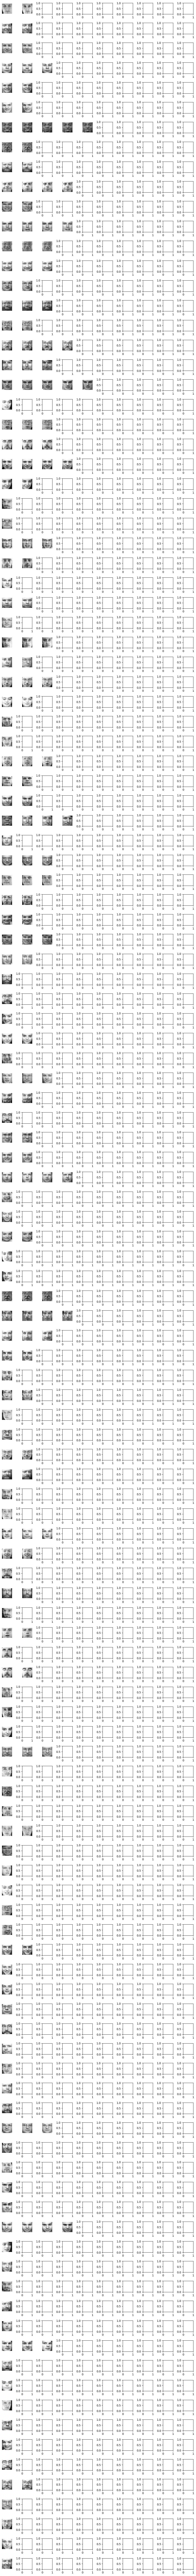

In [3]:

# Visualizamos los clusters y las imágenes más representativas de cada cluster

import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(n, 10, figsize=(10, n))

for cluster in range(n):
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]
    representative_indices = cluster_indices[:10]

    for i, idx in enumerate(representative_indices):
        ax = axes[cluster, i]
        image = np.reshape(X_train[idx], (64, 64))
        ax.imshow(image, cmap='gray')
        ax.axis('off')

# En este grafico lo que se hace es iterar e ir identificando imagenes que se parecen. Se divide en 40 filas, lo cual es la cantidad de personas y cada
# fila tiene 10 columnas pertenecientes a las 10 fotos que hay por persona. 

plt.tight_layout()
plt.show()



In [4]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(X_train, kmeans.labels_)
inertia = kmeans.inertia_
score = kmeans.score(X_train)

print ("Evaluacion de precision por silhouetee: ", silhouette)
print ("Evaluacion de precision por inertia: ", inertia)
print ("Evaluacion de precision por score: ", score)

Evaluacion de precision por silhouetee:  0.18567982
Evaluacion de precision por inertia:  1833.0015869140625
Evaluacion de precision por score:  -1833.001708984375



1. Continuando con el conjunto de datos de caras Olivetti, entrene un clasificador para predecir qué persona está representada en cada imagen y evalúelo en el conjunto de validación. A continuación, utilice K-Means como herramienta de reducción de dimensionalidad y entrene un clasificador en el conjunto reducido. Busque el número de clústeres que permita al clasificador obtener el mejor rendimiento: ¿qué rendimiento puede alcanzar? ¿Qué sucede si agrega las características del conjunto reducido a las características originales (nuevamente, buscando el mejor número de clústeres)?

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


# Elejimos el modelo de RandomForest para entrenar y lo escalamos. Lo hacemos en un pipeline.

pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
pipeline.fit(X_train, y_train)
y_pred_val = pipeline.predict(X_val)

# Evaluar el rendimiento en el conjunto de validación original
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Rendimiento en el conjunto de validación:", val_accuracy)

Rendimiento en el conjunto de validación: 0.875


In [6]:
# Utilizamos K-Means para reducción de dimensionalidad

kmeans = KMeans(n_clusters=n, random_state=42) # n = nro de clusters (130)
kmeans.fit(X_train)

/home/fran/Documentos/5 AÑO/Sistemas Inteligentes carpeta/Sistemas-Inteligentes/sappienv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=130, random_state=42)

In [7]:
# Reducimos la dimensionalidad del conjunto de entrenamiento utilizando los clusters
X_train_reduced = kmeans.transform(X_train)

# Entrenamos RandomForest en el conjunto de entrenamiento reducido
pipeline_reduced = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
pipeline_reduced.fit(X_train_reduced, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [8]:
# Evaluamos el rendimiento en el conjunto de validación reducido
X_val_reduced = kmeans.transform(X_val)
accuracy_reduced = accuracy_score(y_val, pipeline_reduced.predict(X_val_reduced))
print("Rendimiento en conjunto de validación reducido:", accuracy_reduced)

Rendimiento en conjunto de validación reducido: 0.7375


In [9]:
# Combinamos características originales con características del conjunto reducido
X_train_combined = np.hstack((X_train, X_train_reduced))
X_val_combined = np.hstack((X_val, X_val_reduced))

# La función np.hstack() en NumPy se utiliza para apilar matrices horizontalmente, es decir, concatenar matrices a lo largo del segundo eje. 
# hstack toma una secuencia de matrices y las apila horizontalmente para formar una nueva matriz.

In [10]:
# Entrenamos un clasificador en el conjunto de entrenamiento combinado

pipeline_combined = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
pipeline_combined.fit(X_train_combined, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [11]:
# Evaluamos el rendimiento en el conjunto de validación combinado
accuracy_combined = accuracy_score(y_val, pipeline_combined.predict(X_val_combined))
print("Rendimiento en conjunto de validación (combinado):", accuracy_combined)


Rendimiento en conjunto de validación (combinado): 0.8375


In [12]:
# Para comparar mejor todos los rendimientos obtenidos podemos verlos aca juntos

print("Rendimiento en el conjunto de validación:", val_accuracy)
print("Rendimiento en conjunto de validación reducido:", accuracy_reduced)
print("Rendimiento en conjunto de validación (combinado):", accuracy_combined)

Rendimiento en el conjunto de validación: 0.875
Rendimiento en conjunto de validación reducido: 0.7375
Rendimiento en conjunto de validación (combinado): 0.8375


1. Entrene un modelo Gaussian Mixture en el conjunto de datos de caras Olivetti. Para acelerar el algoritmo, probablemente deberá reducir la dimensionalidad del conjunto de datos (por ejemplo, usando PCA, conservando el 99% de la varianza). Utilice el modelo para generar algunas caras nuevas (utilizando el método sample()), y visualícelas (si usó PCA, deberá utilizar su método inverse_transform()). Intente modificar algunas imágenes (por ejemplo, rotar, voltear, oscurecer) y vea si el modelo puede detectar las anomalías (es decir, compare la salida del método score_samples() para imágenes normales y anomalías).

In [17]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt


# Reducción de dimensionalidad con PCA
pca = PCA(n_components=0.99, random_state=42)
X_pca = pca.fit_transform(X)

# Entrenamiento del modelo Gaussian Mixture
gm = GaussianMixture(n_components=40, random_state=42)
gm.fit(X_pca)

GaussianMixture(n_components=40, random_state=42)

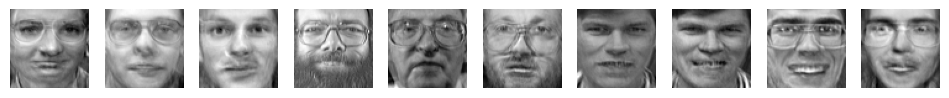

Score de las imágenes originales: [1226.52441905 1112.13015599 1226.52436675 1398.07622109 1112.13007614
 1114.38656049 1226.52440567 1114.3865956  1226.52436807 1112.13005527]
Score de las imágenes modificadas: [-2.83154954e+07 -1.67572406e+07 -7.04191765e+11  1.39807577e+03
  1.11212982e+03  1.11438626e+03  1.22652425e+03  1.11438660e+03
  1.22652431e+03  1.11212995e+03]


In [18]:
# Generar nuevas caras utilizando el modelo
new_faces = gm.sample(n_samples=10)
generated_faces = pca.inverse_transform(new_faces[0])

# Visualizar las nuevas caras generadas
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i, face in enumerate(generated_faces):
    axes[i].imshow(face.reshape(64, 64), cmap='gray')
    axes[i].axis('off')
plt.show()

# Modificar algunas imágenes (rotar, voltear, oscurecer)
modified_faces = X[:10].copy()
modified_faces[0] = np.rot90(modified_faces[0].reshape(64, 64), k=1).ravel()  # Rotar la primera imagen
modified_faces[1] = np.flipud(modified_faces[1].reshape(64, 64)).ravel()  # Voltear verticalmente la segunda imagen
modified_faces[2] = modified_faces[2] * 100  # Oscurecer la tercera imagen

# Evaluar las imágenes originales y modificadas utilizando score_samples()
original_scores = gmm.score_samples(X_pca[:10])
modified_scores = gmm.score_samples(pca.transform(modified_faces))

# Mostrar los resultados
print("Score de las imágenes originales:", original_scores)
print("Score de las imágenes modificadas:", modified_scores)

1. Algunas técnicas de reducción de dimensionalidad también se pueden utilizar para la detección de anomalías. Por ejemplo, tome el conjunto de datos de caras Olivetti y redúzcalo con PCA, conservando el 99% de la varianza. Luego, calcule el error de reconstrucción para cada imagen. A continuación, tome algunas de las imágenes modificadas que construyó en el ejercicio anterior y observe su error de reconstrucción: observe cuánto mayor es el error de reconstrucción. Si traza una imagen reconstruida, verá por qué: intenta reconstruir una cara normal.


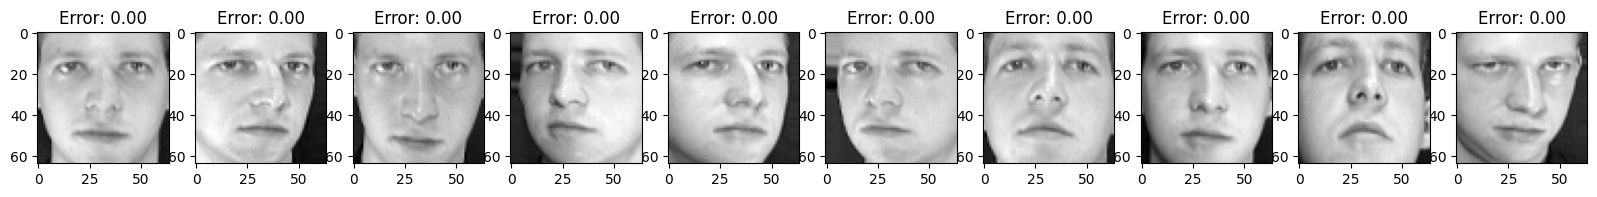

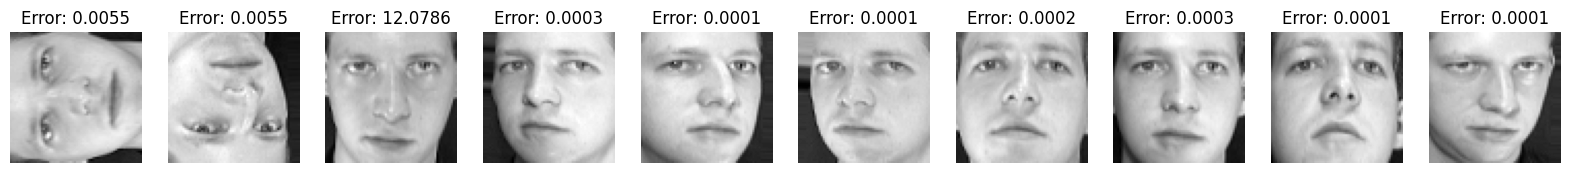

In [19]:
# Calcular el error de reconstrucción para cada imagen
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_errors = np.mean((X - X_reconstructed)**2, axis=1)

# Visualizar algunas imágenes con su error de reconstrucción
fig, axes = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    axes[i].imshow(X[i].reshape(64, 64), cmap='gray')
    axes[i].set_title("Error: {:.2f}".format(reconstruction_errors[i]))

# Calcular el error de reconstrucción para algunas imágenes modificadas
modified_pca = pca.transform(modified_faces)
modified_reconstructed = pca.inverse_transform(modified_pca)
modified_errors = np.mean((modified_faces - modified_reconstructed)**2, axis=1)

# Visualizar las imágenes modificadas con su error de reconstrucción
fig, axes = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    axes[i].imshow(modified_faces[i].reshape(64, 64), cmap='gray')
    axes[i].set_title("Error: {:.4f}".format(modified_errors[i]))
    axes[i].axis('off')
plt.show()


### Preguntas teóricas

1. ¿Cómo definirías el agrupamiento (clustering)? ¿Puedes nombrar algunos algoritmos de clustering?
1. ¿Cuáles son algunas de las principales aplicaciones de los algoritmos de clustering?
1.  Describe dos técnicas para seleccionar el número adecuado de clusters al utilizar K-Means.
1. ¿Qué es la propagación de etiquetas (label propagation)? ¿Por qué la implementarías y cómo?
1. ¿Puedes nombrar dos algoritmos de clustering que puedan escalar a conjuntos de datos grandes? ¿Y dos que busquen regiones de alta densidad?
1. ¿Puedes pensar en un caso de uso donde el aprendizaje activo sería útil? ¿Cómo lo implementarías?
1. ¿Cuál es la diferencia entre la detección de anomalías y la detección de novedades?
1. ¿Qué es un modelo de Gaussian Mixture? ¿Para qué tareas se puede usar?
1. ¿Puedes nombrar dos técnicas para encontrar el número adecuado de clusters al usar un modelo de Gaussian Mixture?